In [1]:
import numpy as np
import pandas as pd
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import re
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, SGDClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn import metrics

In [2]:
df = pd.read_csv("train.csv", nrows=50000)

In [3]:
df.head()

,Id,Title,Body,Tags
0,1,How to check if an uploaded file is an image w...,<p>I'd like to check if an uploaded file is an...,php image-processing file-upload upload mime-t...
1,2,How can I prevent firefox from closing when I ...,"<p>In my favorite editor (vim), I regularly us...",firefox
2,3,R Error Invalid type (list) for variable,<p>I am import matlab file and construct a dat...,r matlab machine-learning
3,4,How do I replace special characters in a URL?,"<p>This is probably very simple, but I simply ...",c# url encoding
4,5,How to modify whois contact details?,<pre><code>function modify(.......)\n{\n $mco...,php api file-get-contents


In [4]:
# df2 = df.append(df.iloc[[4,10, 4]], ignore_index=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 4 columns):
Id       50000 non-null int64
Title    50000 non-null object
Body     50000 non-null object
Tags     50000 non-null object
dtypes: int64(1), object(3)
memory usage: 1.5+ MB


In [6]:
# df2 = df2.drop(["Id"], axis=1)

In [7]:
# df_no_dup = df2[df2.duplicated() == False]
df.drop(["Id"], inplace = True, axis=1)
df_no_dup = df[df.duplicated() == False]
df_no_dup.head()

,Title,Body,Tags
0,How to check if an uploaded file is an image w...,<p>I'd like to check if an uploaded file is an...,php image-processing file-upload upload mime-t...
1,How can I prevent firefox from closing when I ...,"<p>In my favorite editor (vim), I regularly us...",firefox
2,R Error Invalid type (list) for variable,<p>I am import matlab file and construct a dat...,r matlab machine-learning
3,How do I replace special characters in a URL?,"<p>This is probably very simple, but I simply ...",c# url encoding
4,How to modify whois contact details?,<pre><code>function modify(.......)\n{\n $mco...,php api file-get-contents


In [8]:
print("number of duplicate entries: ", len(df) - len(df_no_dup), "(",(1 - len(df_no_dup)/len(df))*100,"%)")

number of duplicate entries:  143 ( 0.28599999999999737 %)


In [9]:
# len(df.Tags.apply(lambda))
df_no_dup["tag_count"] = df_no_dup.Tags.apply(lambda x: len(x.split()))
df_no_dup.head()

C:\Users\pradeep\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,Title,Body,Tags,tag_count
0,How to check if an uploaded file is an image w...,<p>I'd like to check if an uploaded file is an...,php image-processing file-upload upload mime-t...,5
1,How can I prevent firefox from closing when I ...,"<p>In my favorite editor (vim), I regularly us...",firefox,1
2,R Error Invalid type (list) for variable,<p>I am import matlab file and construct a dat...,r matlab machine-learning,3
3,How do I replace special characters in a URL?,"<p>This is probably very simple, but I simply ...",c# url encoding,3
4,How to modify whois contact details?,<pre><code>function modify(.......)\n{\n $mco...,php api file-get-contents,3


In [10]:
df_no_dup.tag_count.value_counts()

3    14436
2    13233
4     9536
1     6827
5     5825
Name: tag_count, dtype: int64

In [11]:
df_no_dup = df_no_dup.drop(["tag_count"], axis=1)

In [12]:
tag_vectorizer = CountVectorizer()
tag_vectors = tag_vectorizer.fit_transform(df_no_dup.Tags)

In [13]:
print("Tag dimension: ", len(tag_vectorizer.get_feature_names()))

Tag dimension:  10034


In [28]:
tag_doc_freq = dict(zip(tag_vectorizer.get_feature_names(), tag_vectors.sum(axis=0).A1))

In [29]:
len((tag_doc_freq))

10034

In [30]:
tags_df = pd.DataFrame.from_dict(tag_doc_freq, orient='index')
tags_df.reset_index(level=0, inplace=True)
tags_df.columns = ["Tags", "Count"]
tags_df.head()

,Tags,Count
0,where,10
1,radiobuttonlist,2
2,egit,2
3,catalyst,4
4,unity3d,16


In [31]:
# plt.title("Tag Distribution")
# plt.plot(tags_df.Count.sort_values(ascending=False).values)
# plt.xlabel("num")
# plt.ylabel("freq")
# plt.show()

# df_tags_sorted_by_freq = tags_df.sort()
# plt.title("Tag Distribution")

# plt.show()

# tags_df.Count.sort_values(ascending=False).index
tags_df_sorted_by_freq = tags_df.iloc[tags_df.Count.sort_values(ascending=False).index]
tags_df_sorted_by_freq.head()

,Tags,Count
2734,net,4489
6982,java,3639
5511,android,3563
7751,php,3325
4092,javascript,3230


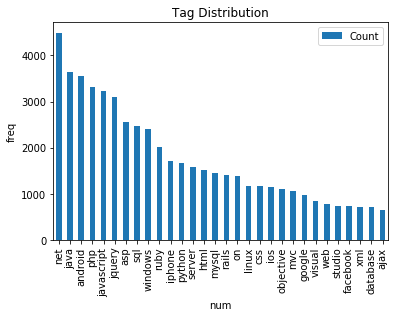

In [32]:
# 
tags_df_sorted_by_freq.head(30).plot(kind="bar")
plt.title("Tag Distribution")
plt.xticks(np.arange(0,30), tags_df_sorted_by_freq.Tags)
plt.xlabel("num")
plt.ylabel("freq")
plt.show()


In [33]:
#normalize text

In [34]:
stop_words = set(stopwords.words('english'))
stemmer    = PorterStemmer()

def normalize_text(text):
    title         = text[0].encode('utf-8')
    code_in_ques  = ''.join(re.findall('<code>(.*?)</code>',text[1], flags=re.MULTILINE|re.DOTALL))
    ques_reminder = BeautifulSoup(re.sub('<code>(.*?)</code>','', text[1], flags=re.MULTILINE|re.DOTALL), "lxml").text
    
    ques = str(title)+" "+str(title)+" "+str(title) + " " + str(ques_reminder)
    ques = re.sub(r'[^A-Za-z]+', ' ', ques)
    
    ques = ' '.join(list(map(stemmer.stem, [word for word in word_tokenize(ques.lower()) if word not in stop_words and len(word) > 1 or word == 'c'] )))
    
    return pd.Series([ques, code_in_ques, text[2], '<code>' in text[1]], index=['Ques', 'Code', 'Tags', 'is_code'])

In [35]:
# %%time
# dx = df_no_dup[4:5].apply(lambda x: normalize_text(x), axis=1)
# df_no_dup

In [36]:
df_norm = pd.DataFrame(columns=["Ques", "Code", "Tags", "is_code"])

In [37]:
%%time
df_norm = pd.DataFrame(df_no_dup.apply(lambda x: normalize_text(x), axis=1))

Wall time: 3min 5s


In [38]:
df_norm.head()

,Ques,Code,Tags,is_code
0,check upload file imag without mime type check...,,php image-processing file-upload upload mime-t...,False
1,prevent firefox close press ctrl prevent firef...,,firefox,False
2,error invalid type list variabl error invalid ...,Error in model.frame.default(formula = expert_...,r matlab machine-learning,True
3,replac special charact url replac special char...,,c# url encoding,False
4,modifi whoi contact detail modifi whoi contact...,function modify(.......)\n{\n $mcontact = fil...,php api file-get-contents,True


In [39]:
#modelling

In [40]:
tag_vectorizer = CountVectorizer(tokenizer = lambda x: x.split(), binary=True)
tag_vectors = tag_vectorizer.fit_transform(df_norm.Tags)

In [41]:
len(tag_vectorizer.get_feature_names())

13892

In [43]:
def tags_to_choose(n):
    return np.argpartition(tag_vectors.sum(axis=0).tolist()[0], -n)[-n:]

In [44]:
# tags_to_choose(4)

In [45]:
# most_frequent_tags = tags_to_choose(4)
# tag_vectors[:,most_frequent_tags].toarray()

In [46]:
ques_explained = []
total_ques = len(df_no_dup)
for i in range(1, len(tag_vectorizer.get_feature_names()), 5):#increase range for final implementation
    num_ques_with_tags = np.count_nonzero(tag_vectors[:,tags_to_choose(i)].sum(axis=1))
    ques_explained.append(np.round((num_ques_with_tags/total_ques)*100))

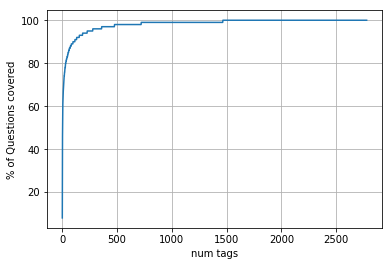

In [47]:
plt.plot(ques_explained)
plt.xlabel("num tags")
plt.ylabel("% of Questions covered")
plt.grid()
plt.show()

In [48]:
#trade-off: compute time vs. %of questions covered
finalist_tags = tag_vectors[:,tags_to_choose(250)]

In [49]:
features_train, features_test, target_train, target_test = train_test_split(df_norm[["Ques", "is_code"]], finalist_tags, test_size=0.2)

In [50]:
#feature extraction

In [51]:
%%time
# feature_vectorizer = CountVectorizer(ngram_range=(1,4), max_features=2000, max_df=0.9, min_df=0.1, binary=True)
feature_vectorizer = CountVectorizer(ngram_range=(1,4), max_features=2000, binary=True)
feat_train_ngram = feature_vectorizer.fit_transform(features_train['Ques'])
feat_test_ngram  = feature_vectorizer.transform(features_test['Ques'])

Wall time: 37.6 s


In [52]:
# feat_train_ngram[0].toarray()

In [53]:
%%time
# model = OneVsRestClassifier(LogisticRegressionCV(Cs=3,  n_jobs=-1, penalty = "l2", solver="saga", refit = True, multi_class="ovr"))
model = OneVsRestClassifier(SGDClassifier(loss='hinge'))
model.fit(feat_train_ngram, target_train)

# model = OneVsRestClassifier(LogisticRegression(n_jobs=-1, penalty = "l2", solver="saga", multi_class="ovr"))
# model.fit(feat_train_ngram, target_train)


C:\Users\pradeep\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\pradeep\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\pradeep\Anaconda3\l

C:\Users\pradeep\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\pradeep\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\pradeep\Anaconda3\l

C:\Users\pradeep\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\pradeep\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\pradeep\Anaconda3\l

C:\Users\pradeep\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\pradeep\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\pradeep\Anaconda3\l

C:\Users\pradeep\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\pradeep\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\pradeep\Anaconda3\l

C:\Users\pradeep\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\pradeep\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\pradeep\Anaconda3\l

C:\Users\pradeep\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\pradeep\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\pradeep\Anaconda3\l

C:\Users\pradeep\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\pradeep\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\pradeep\Anaconda3\l

C:\Users\pradeep\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\pradeep\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\pradeep\Anaconda3\l

C:\Users\pradeep\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\pradeep\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\pradeep\Anaconda3\l

C:\Users\pradeep\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\pradeep\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\pradeep\Anaconda3\l

C:\Users\pradeep\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\pradeep\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\pradeep\Anaconda3\l

C:\Users\pradeep\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\pradeep\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\pradeep\Anaconda3\l

Wall time: 14.5 s


C:\Users\pradeep\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


In [54]:
predictions = model.predict(feat_test_ngram)

print("accuracy :",metrics.accuracy_score(target_test,predictions))
print("macro f1 score :",metrics.f1_score(target_test, predictions, average = 'macro'))
print("micro f1 scoore :",metrics.f1_score(target_test, predictions, average = 'micro'))
print("hamming loss :",metrics.hamming_loss(target_test,predictions))
print("Precision recall report :\n",metrics.classification_report(target_test, predictions))

accuracy : 0.24298034496590454
macro f1 score : 0.2500678526254982
micro f1 scoore : 0.42046309454150294
hamming loss : 0.005561973525872443
Precision recall report :
              precision    recall  f1-score   support

          0       0.00      0.00      0.00        19
          1       0.75      0.14      0.23        22
          2       0.14      0.12      0.13         8
          3       0.85      0.46      0.59        24
          4       0.25      0.06      0.10        16
          5       0.00      0.00      0.00        19
          6       0.00      0.00      0.00        21
          7       0.00      0.00      0.00         9
          8       0.33      0.06      0.10        17
          9       0.00      0.00      0.00        14
         10       0.50      0.08      0.13        13
         11       0.12      0.06      0.08        18
         12       0.00      0.00      0.00        17
         13       0.00      0.00      0.00        17
         14       0.14      0.05    

C:\Users\pradeep\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\pradeep\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [57]:
%%time
model2 = OneVsRestClassifier(LogisticRegressionCV(Cs=3,  n_jobs=-1, penalty = "l2", solver="saga", refit = True, multi_class="ovr"))
model2.fit(feat_train_ngram, target_train)


C:\Users\pradeep\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\pradeep\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\pradeep\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\pradeep\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\pradeep\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_

C:\Users\pradeep\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\pradeep\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\pradeep\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\pradeep\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\pradeep\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_

C:\Users\pradeep\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\pradeep\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\pradeep\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\pradeep\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\pradeep\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_

C:\Users\pradeep\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\pradeep\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\pradeep\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\pradeep\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\pradeep\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_

C:\Users\pradeep\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\pradeep\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\pradeep\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\pradeep\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\pradeep\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_

C:\Users\pradeep\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\pradeep\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\pradeep\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\pradeep\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\pradeep\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_

C:\Users\pradeep\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\pradeep\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\pradeep\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\pradeep\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\pradeep\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_

Wall time: 2h 3min 12s


In [58]:
predictions = model.predict(feat_test_ngram)

print("accuracy :",metrics.accuracy_score(target_test,predictions))
print("macro f1 score :",metrics.f1_score(target_test, predictions, average = 'macro'))
print("micro f1 scoore :",metrics.f1_score(target_test, predictions, average = 'micro'))
print("hamming loss :",metrics.hamming_loss(target_test,predictions))
print("Precision recall report :\n",metrics.classification_report(target_test, predictions))

accuracy : 0.24298034496590454
macro f1 score : 0.2500678526254982
micro f1 scoore : 0.42046309454150294
hamming loss : 0.005561973525872443
Precision recall report :
              precision    recall  f1-score   support

          0       0.00      0.00      0.00        19
          1       0.75      0.14      0.23        22
          2       0.14      0.12      0.13         8
          3       0.85      0.46      0.59        24
          4       0.25      0.06      0.10        16
          5       0.00      0.00      0.00        19
          6       0.00      0.00      0.00        21
          7       0.00      0.00      0.00         9
          8       0.33      0.06      0.10        17
          9       0.00      0.00      0.00        14
         10       0.50      0.08      0.13        13
         11       0.12      0.06      0.08        18
         12       0.00      0.00      0.00        17
         13       0.00      0.00      0.00        17
         14       0.14      0.05    

C:\Users\pradeep\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\pradeep\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
